<a href="https://colab.research.google.com/github/LZHbaba/lzh_garbage_classification/blob/main/SE_ResNet152_20_last20_4_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets 
train_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
valid_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'


# extract images to training set by applying data preprocessing and data augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='training')


# extract images to validation set
val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='validation')
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

print(1)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
1


In [ ]:
import urllib.request
from tensorflow.keras import layers, models
def se_identity_block(inputs, filters, name, strides=1, reduce_ratio=8, training=True):
    """
    se_resnet卷积块
    :param inputs: 卷积块的输入
    :param filters: 卷积核的数量
    :param name: 卷积块名字相关
    :param strides: 为1时候不改变特征层宽高，为2就减半
    :param reduce_ratio: se block的衰减倍数，用于减少参数量
    :param training: 是否是训练模式
    :return : x
    """
    filter1, filter2, filter3 = filters

    x = layers.Conv2D(filter1, kernel_size=1, strides=strides, name=name+'_1_conv')(inputs)
    x = layers.BatchNormalization(name=name+'_1_bn')(x, training=training)
    x = layers.ReLU(name=name + '_1_relu')(x)

    x = layers.Conv2D(filter2, kernel_size=3, strides=strides, padding='same', name=name+'_2_conv')(x)
    x = layers.BatchNormalization(name=name+'_2_bn')(x, training=training)
    x = layers.ReLU(name=name + '_2_relu')(x)

    x = layers.Conv2D(filter3, kernel_size=1, strides=strides, name=name+'_3_conv')(x)
    x = layers.BatchNormalization(name=name+'_3_bn')(x, training=training)

    se_input = x
    x = layers.GlobalAveragePooling2D(name=name+'avg')(se_input)
    x = layers.Reshape((1, 1, filter3), name=name+'reshape')(x)
    x = layers.Dense(filter3 // reduce_ratio, activation='relu', name=name+'dense_relu')(x)
    x = layers.Dense(filter3, activation='sigmoid', name=name+'dense_sigmoid')(x)
    x = layers.Multiply(name=name+'multiply')([x, se_input])

    x = layers.Add(name=name + '_add')([x, inputs])
    x = layers.ReLU(name=name + '_out')(x)

    return x


def se_conv_block(inputs, filters, name, strides=1, reduce_ratio=8, training=True):
    """
    se_bottleneck卷积块
    :param inputs: 卷积块的输入
    :param filters: 卷积核的数量
    :param name: 卷积块名字相关
    :param strides: 为1时候不改变特征层宽高，为2就减半
    :param reduce_ratio: se block的衰减倍数，用于减少参数量
    :param training: 是否是训练模式
    :return : x
    """
    filter1, filter2, filter3 = filters

    shortcut = layers.Conv2D(filter3, kernel_size=1, strides=strides, name=name+'_0_conv')(inputs)
    shortcut = layers.BatchNormalization(name=name+'_0_bn')(shortcut, training=training)

    x = layers.Conv2D(filter1, kernel_size=1, strides=strides, name=name+'_1_conv')(inputs)
    x = layers.BatchNormalization(name=name+'_1_bn')(x, training=training)
    x = layers.ReLU(name=name + '_1_relu')(x)

    x = layers.Conv2D(filter2, kernel_size=3, padding='same', name=name+'_2_conv')(x)
    x = layers.BatchNormalization(name=name+'_2_bn')(x, training=training)
    x = layers.ReLU(name=name + '_2_relu')(x)

    x = layers.Conv2D(filter3, kernel_size=1, name=name+'_3_conv')(x)
    x = layers.BatchNormalization(name=name+'_3_bn')(x, training=training)

    se_input = x
    x = layers.GlobalAveragePooling2D(name=name+'avg')(se_input)
    x = layers.Reshape((1, 1, filter3), name=name+'reshape')(x)
    x = layers.Dense(filter3 // reduce_ratio, activation='relu', name=name+'dense_relu')(x)
    x = layers.Dense(filter3, activation='sigmoid', name=name+'dense_sigmoid')(x)
    x = layers.Multiply(name=name+'multiply')([x, se_input])

    x = layers.Add(name=name + '_add')([x, shortcut])
    x = layers.ReLU(name=name + '_out')(x)

    return x


def SE_ResNet_stage(inputs, filters, num_block, name, strides):
    """
    ResNet中一个stage结构
    :param inputs: stage的输入
    :param filters: 每个卷积块对应卷积核的数量
    :param num_block: 卷积块重复的数量
    :param name: 该卷积块的名字前缀
    :param strides: 步长
    :return: x
    """
    x = se_conv_block(inputs, filters, name=name+'_block1', strides=strides)
    for i in range(1, num_block):
        x = se_identity_block(x, filters, name=name+'_block'+str(i+1))

    return x


def SE_ResNet(input_shape, num_classes, blocks_list, include_top=False):
    """
    ResNet网络结构，通过传入不同的残差块和重复的次数进行不同层数的ResNet构建
    :param input_shape: 网络输入shape
    :param num_classes: 分类数量
    :param blocks_list: 每个残差单元重复的次数列表
    :param include_top: 是否包含分类层
    :return: model
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(inputs)

    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, name='conv1_conv')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv1_bn')(x)
    x = layers.ReLU(name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name="pool1_pool")(x)

    x = SE_ResNet_stage(x, [64, 64, 256], blocks_list[0], name='conv2', strides=1)
    x = SE_ResNet_stage(x, [128, 128, 512], blocks_list[1], name='conv3', strides=2)
    x = SE_ResNet_stage(x, [256, 256, 1024], blocks_list[2], name='conv4', strides=2)
    x = SE_ResNet_stage(x, [512, 512, 2048], blocks_list[3], name='conv5', strides=2)

    x = layers.GlobalAvgPool2D(name='avg_pool')(x)

    if include_top:
        outputs = layers.Dense(num_classes, name="prediction", activation="softmax")(x)
    else:
        outputs = x

    model = models.Model(inputs=inputs, outputs=outputs)

    return model



def SE_ResNet152(input_shape, num_classes, include_top=False, weights='imagenet'):
    model = SE_ResNet(input_shape, num_classes, [3, 8, 36, 3], include_top=include_top)
    model._name = 'se_resnet152'

    if weights == 'imagenet':
        url = 'https://github.com/Runist/image-classifier-keras/releases/download/v0.2/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = './pretrain_weights/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5'
        if not os.path.exists(weights_path):
            print("Downloading data from {}".format(url))
            urllib.request.urlretrieve(url, weights_path)

        model.load_weights(weights_path, by_name=True, skip_mismatch=True)

    return model

import os
from tensorflow.keras import layers, models


def get_model(network, input_shape, num_classes, include_top=True):
    if not os.path.exists("pretrain_weights"):
        os.mkdir("pretrain_weights")

    
    elif network == "se_resnet50":
        model = SE_ResNet50(input_shape, num_classes, include_top=include_top, weights="imagenet")
        #base_model.summary()
    elif network == "se_resnet101":
        model = SE_ResNet101(input_shape, num_classes, include_top=include_top, weights="imagenet")
    elif network == "se_resnet152":
        model = SE_ResNet152(input_shape, num_classes, include_top=include_top, weights="imagenet")
    else:
        raise Exception("You don't select any model. Check config.py network name.")

    outputs = model.layers[-1].output

    model = models.Model(inputs=model.inputs, outputs=outputs, name=model.name)

    return model

from tensorflow.keras import layers, models
if __name__ == '__main__':
   
    model = get_model(network='se_resnet152', input_shape=IMG_SHAPE , num_classes=6, include_top=False)
    model2 = Sequential()
    model.trainable=False
    model2.add(model)
    #model.add(GlobalAveragePooling2D())
    model2.add(Dense(units=512, activation='relu'))  # use ReLU activation function
    model2.add(BatchNormalization())                 # normalize and scale inputs or activations
    model2.add(Dropout(0.5))                         # applies dopout to the input which will randomly disable 20% of hidden units

    model2.add(Dense(units=128, activation='relu')) # use ReLU activation function
    model2.add(BatchNormalization())                # normalize and scale inputs or activations
    model2.add(Dropout(0.5))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
    model2.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
    model2.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 se_resnet152 (Functional)   (None, 2048)              71581152  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

Epoch 1/20
142/142 [==============================] - 697s 5s/step - loss: 0.9291 - accuracy: 0.6995 - val_loss: 0.6613 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 2/20
142/142 [==============================] - 84s 589ms/step - loss: 0.5674 - accuracy: 0.8018 - val_loss: 0.4704 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/20
142/142 [==============================] - 84s 587ms/step - loss: 0.4906 - accuracy: 0.8348 - val_loss: 0.6284 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 4/20
142/142 [==============================] - 84s 591ms/step - loss: 0.3855 - accuracy: 0.8647 - val_loss: 0.5858 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 5/20
142/142 [==============================] - 84s 592ms/step - loss: 0.3729 - accuracy: 0.8704 - val_loss: 0.4971 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 6/20
143/142 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9038
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
142/142 [==============================

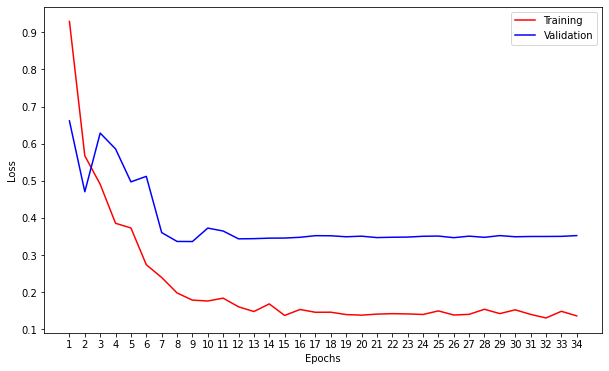

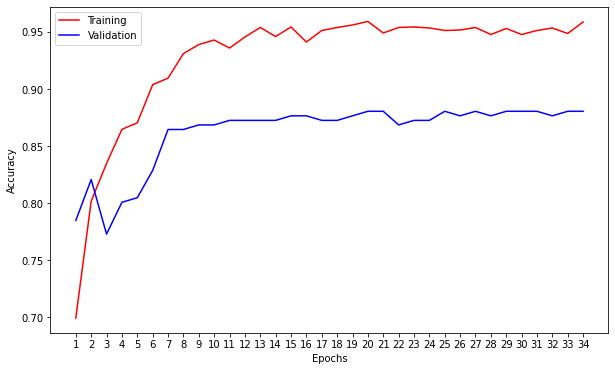

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,EarlyStopping

# https://blog.csdn.net/qq_34418352/article/details/105152893
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                               cooldown=0,
                               patience=4,
                               min_lr=0,
                               verbose=1,
                               mode='auto',
                               epsilon=0.001)
# 自动减小学习速率： https://blog.csdn.net/weixin_44048809/article/details/105711356； patience比EarlyStopping小一点才有效果，和早挺搭配使用
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=8)
# https://blog.csdn.net/zwqjoy/article/details/86677030

callbacks = [lr_reducer,es]


import time
start = time.time()
history = model2.fit(
   train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size,
    verbose=1,
    callbacks = callbacks)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy =history.history['val_accuracy']

for layer in model2.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
#base_model.trainable=True
history = model2.fit(
   train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size,
    verbose=1,
    callbacks = callbacks)
loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])
time_used = time.time()-start
print(time_used)


def save_txt(file_name='',object=[]):
    file = open(file_name, 'w')
    file.write(str(object))
    file.close()

model.save_weights('/content/drive/MyDrive/seresnet152_20_last20_4_8/seresnet152_20_last20_4_8_parameter.h5')#保存模型参数
save_txt('/content/drive/MyDrive/seresnet152_20_last20_4_8/loss_seresnet152_20_last20_4_8.txt',loss)
save_txt('/content/drive/MyDrive/seresnet152_20_last20_4_8/val_loss_seresnet152_20_last20_4_8.txt',validation_loss)
save_txt('/content/drive/MyDrive/seresnet152_20_last20_4_8/acc_seresnet152_20_last20_4_8.txt',accuracy)
save_txt('/content/drive/MyDrive/seresnet152_20_last20_4_8/val_acc_seresnet152_20_last20_4_8.txt',validation_accuracy)

epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

epochs1 = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs1,accuracy,c="red",label="Training")
plt.plot(epochs1,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs1)
plt.legend()

NameError: ignored